In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [6]:
from dotenv import load_dotenv
import os
from graphdatascience import GraphDataScience


/Users/abhisheknarisepallivenkatasai/SUPPLY_CHAIN_OPTIMIZATION/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
load_dotenv()
uri = os.getenv("NEO4J_URI")
user = os.getenv("NEO4J_USER")
pwd = os.getenv("NEO4J_PASSWORD")

In [8]:
gds = GraphDataScience(uri, auth=(user, pwd))

In [9]:
# Create the in-memory graph projection
g, _ = gds.graph.project('proj', 'Airport', {'SENDS_TO':{'properties':['flightCount']}})

In [10]:
# calculate and write out-degree centrality
gds.degree.write(g,relationshipWeightProperty='flightCount', writeProperty='outDegreeCentrality')
# calculate and write betweenness centrality
gds.betweenness.write(g, writeProperty='betweennessCentrality')
#calculate and write eigenvector centrality
gds.eigenvector.write(g,relationshipWeightProperty='flightCount', writeProperty='eigenvectorCentrality')
# drop the projected in-memory graph
g.drop()

graphName                                                             proj
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                              237
relationshipCount                                                     1205
configuration            {'relationshipProjection': {'SENDS_TO': {'aggr...
density                                                           0.021544
creationTime                           2025-10-27T19:06:25.469479000+05:30
modificationTime                       2025-10-27T19:06:25.469479000+05:30
schema                   {'graphProperties': {}, 'nodes': {'Airport': {...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'Airport': {...
Name: 0, dtype: object

In [11]:
g, _ = gds.graph.project('proj', 'Airport', {'SENDS_TO':{'orientation':'REVERSE', 'properties':['flightCount']}})
gds.degree.write(g,relationshipWeightProperty='flightCount', writeProperty='inDegreeCentrality')
g.drop()

graphName                                                             proj
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                              237
relationshipCount                                                     1205
configuration            {'relationshipProjection': {'SENDS_TO': {'aggr...
density                                                           0.021544
creationTime                           2025-10-27T19:07:19.793716000+05:30
modificationTime                       2025-10-27T19:07:19.793716000+05:30
schema                   {'graphProperties': {}, 'nodes': {'Airport': {...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'Airport': {...
Name: 0, dtype: object

In [12]:
metrics = ['betweennessCentrality', 'outDegreeCentrality', 'inDegreeCentrality', 'eigenvectorCentrality']
top_n = 5
for metric in metrics:
    print('\n=======================================')
    print(f'Top {top_n} Airports for {metric}')
    print(gds.run_cypher(f'''
        MATCH(a:Airport)
        RETURN a.airportId AS airportId, a.name AS name, a.{metric} AS {metric}
        ORDER BY {metric} DESC LIMIT {top_n}
    '''))


Top 5 Airports for betweennessCentrality
   airportId         name  betweennessCentrality
0        349  Richardberg           11579.601583
1        128    Shanefort           10715.139355
2        700    Davisfort            5178.707487
3        815    Moodytown            4471.174851
4        555  Masseyhaven            3722.941825

Top 5 Airports for outDegreeCentrality
   airportId         name  outDegreeCentrality
0        815    Moodytown               2240.0
1        128    Shanefort               2195.0
2        700    Davisfort               2003.0
3        349  Richardberg               1104.0
4        485  Michaelstad                711.0

Top 5 Airports for inDegreeCentrality
   airportId         name  inDegreeCentrality
0        700    Davisfort              2205.0
1        128    Shanefort              1839.0
2        349  Richardberg              1312.0
3        815    Moodytown              1091.0
4        485  Michaelstad               758.0

Top 5 Airports for eigenve

In [30]:
print('\n=======================================')
print(f'Top {top_n} Airports by Total Degree Centrality (In + Out)')
print(gds.run_cypher('''
    MATCH(a:Airport)
    RETURN a.airportId AS airportId, 
           a.name AS name, 
           a.inDegreeCentrality AS inDegree,
           a.outDegreeCentrality AS outDegree,
           (a.inDegreeCentrality + a.outDegreeCentrality) AS totalDegreeCentrality
    ORDER BY totalDegreeCentrality DESC 
    LIMIT 5
'''))



Top 5 Airports by Total Degree Centrality (In + Out)
   airportId         name  inDegree  outDegree  totalDegreeCentrality
0        700    Davisfort    2205.0     2003.0                 4208.0
1        128    Shanefort    1839.0     2195.0                 4034.0
2        815    Moodytown    1091.0     2240.0                 3331.0
3        349  Richardberg    1312.0     1104.0                 2416.0
4        485  Michaelstad     758.0      711.0                 1469.0


In [13]:
#combined into a single table for top 5 betweenness centrality
gds.run_cypher(f'''
        MATCH(a:Airport)
        RETURN a.airportId AS airportId, a.name AS name,
            a.betweennessCentrality AS betweennessCentrality,
            a.outDegreeCentrality AS outDegreeCentrality,
            a.inDegreeCentrality AS inDegreeCentrality,
            a.eigenvectorCentrality AS eigenvectorCentrality
        ORDER BY betweennessCentrality DESC LIMIT {top_n}
''')

,airportId,name,betweennessCentrality,outDegreeCentrality,inDegreeCentrality,eigenvectorCentrality
0,349,Richardberg,11579.601583,1104.0,1312.0,0.455872
1,128,Shanefort,10715.139355,2195.0,1839.0,0.439031
2,700,Davisfort,5178.707487,2003.0,2205.0,0.643818
3,815,Moodytown,4471.174851,2240.0,1091.0,0.255747
4,555,Masseyhaven,3722.941825,275.0,204.0,0.046118


In [14]:
g, _ = gds.graph.project('proj', 'Airport', {'SENDS_TO':{'orientation':'UNDIRECTED', 'properties':['flightCount']}})
gds.louvain.write(g, relationshipWeightProperty='flightCount', writeProperty='louvainId')
g.drop()

graphName                                                             proj
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                              237
relationshipCount                                                     2410
configuration            {'relationshipProjection': {'SENDS_TO': {'aggr...
density                                                           0.043088
creationTime                           2025-10-27T19:08:40.367064000+05:30
modificationTime                       2025-10-27T19:08:40.367064000+05:30
schema                   {'graphProperties': {}, 'nodes': {'Airport': {...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'Airport': {...
Name: 0, dtype: object

In [15]:
# Relabel Louvain Communities (a.k.a. Regions) by the highest betweenness centrality airport name
gds.run_cypher('''
    MATCH (a:Airport)
    WITH a.louvainId AS louvainId, max(a.betweennessCentrality) as maxBC
    MATCH(a:Airport) WHERE a.betweennessCentrality = maxBC
    WITH a.name as regionLabel, louvainId
    MATCH(a:Airport) WHERE a.louvainId=louvainId
    SET a.regionLabel = regionLabel
    RETURN count(a)
''')

,count(a)
0,237


In [16]:
# Count the number of airports in each region
gds.run_cypher('''
    MATCH (a:Airport)
    RETURN a.regionLabel as region, count(a) AS numberOfAirports
    ORDER BY region
''')

,region,numberOfAirports
0,Davisfort,32
1,Masseyhaven,50
2,Moodytown,51
3,Richardberg,48
4,Shanefort,56


In [17]:
# get the data
DELAY_CUTOFF = 30.0
df_raw = gds.run_cypher('''
    MATCH(a:Airport)<-[:LOCATED_AT]-()<-[r:TRANSPORT]-()-[:LOCATED_AT]->(b)
    WITH a, toInteger((r.effectiveMinutes-r.plannedMinutes) > $delayCutoff) AS wasDelayed,
        r.effectiveMinutes-r.plannedMinutes as delay,
        toInteger(a.regionLabel <> b.regionLabel) AS interRegion,
        b.outDegreeCentrality AS sourceOutDegree,
        b.name AS sourceName,
        b.airportId as sourceAirportId
    RETURN a.airportId as airportId,
        a.name AS name,
        sourceAirportId,
        sourceName,
        wasDelayed,
        delay,
        interRegion,
        sourceOutDegree,
        a.inDegreeCentrality AS inDegreeCentrality,
        a.outDegreeCentrality AS outDegreeCentrality,
        a.betweennessCentrality AS betweennessCentrality,
        a.eigenvectorCentrality AS eigenvectorCentrality,
        a.regionLabel AS regionLabel
''', params = {'delayCutoff': DELAY_CUTOFF})

In [18]:
df_raw.wasDelayed.value_counts()

wasDelayed
0    13984
1     2183
Name: count, dtype: int64

In [19]:
# subsample to airports with 100 or more arrivals
airports = df_raw.airportId.value_counts()
df = df_raw[df_raw.airportId.isin(airports[airports >= 100].index.to_list())]

In [20]:
# create airport fixed effects and intercept
df = pd.concat([df, pd.get_dummies(df.airportId, drop_first=True, prefix='airport')], axis=1)
df['intercept'] = 1

In [22]:
#log centrality variables
df['logBetweenness'] = np.log(df.betweennessCentrality + 1.0)
df['logEigenvector'] = np.log(df.eigenvectorCentrality + 1.0)
df['logInDegree'] = np.log(df.inDegreeCentrality + 1.0)
df['logOutDegree'] = np.log(df.outDegreeCentrality + 1.0)
df['logSourceOutDegree'] = np.log(df.sourceOutDegree + 1.0)

In [23]:
# check final class balance
df.wasDelayed.value_counts()

wasDelayed
0    11084
1     1678
Name: count, dtype: int64

Fit a Logistic Regression model to predict delays based on centrality measures.

In [24]:
# Convert boolean airport columns to integers (0/1)
airport_cols = [col for col in df.columns if col.startswith('airport_')]
df[airport_cols] = df[airport_cols].astype(int)


In [25]:
x_cols = ['logBetweenness',  'logInDegree', 'logOutDegree',
          'logEigenvector', 'interRegion','logSourceOutDegree', 'intercept']\
         + airport_cols

In [26]:
mod = sm.Logit(df.wasDelayed, df[x_cols])
res = mod.fit(cov_type='cluster', maxiter=10000, cov_kwds={'groups': df.airportId})
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.339952
         Iterations 1245
                           Logit Regression Results                           
Dep. Variable:             wasDelayed   No. Observations:                12762
Model:                          Logit   Df Residuals:                    12723
Method:                           MLE   Df Model:                           38
Date:                Mon, 27 Oct 2025   Pseudo R-squ.:                  0.1265
Time:                        19:26:06   Log-Likelihood:                -4338.5
converged:                       True   LL-Null:                       -4966.9
Covariance Type:              cluster   LLR p-value:                4.286e-239
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
logBetweenness         0.1269      0.011     11.788      0.000       0.106       0.148
lo

In [28]:
df.to_csv('ohe_df.csv')

In [41]:
# Get all unique source-destination pairs from your transport data
transport_pairs = gds.run_cypher('''
    MATCH (source:Airport)<-[:LOCATED_AT]-()-[:TRANSPORT]-()-[:LOCATED_AT]->(dest:Airport)
    WHERE source <> dest
    RETURN DISTINCT source.name as sourceName, 
           dest.name as destName,
           source.airportId as sourceId,
           dest.airportId as destId,
           count(*) as shipmentCount
    ORDER BY shipmentCount DESC
    LIMIT 50
''')
print("Top 50 Airport Pairs with Most Shipments:")
print(transport_pairs)


Top 50 Airport Pairs with Most Shipments:
       sourceName       destName  sourceId  destId  shipmentCount
0       Moodytown    Michaelstad       815     485            511
1     Michaelstad      Moodytown       485     815            511
2       Davisfort      Scotttown       700     671            446
3       Scotttown      Davisfort       671     700            446
4       Shanefort      Davisfort       128     700            325
5       Davisfort      Shanefort       700     128            325
6       Davisfort    Michaelstad       700     485            322
7     Michaelstad      Davisfort       485     700            322
8     Richardberg      Scotttown       349     671            257
9       Scotttown    Richardberg       671     349            257
10      Shanefort    Stephenside       128     411            224
11    Stephenside      Shanefort       411     128            224
12      Moodytown      Davisfort       815     700            220
13      Davisfort      Moodytown  

In [42]:
df['prob'] = res.predict(df[x_cols])
df.loc[df.name.isin(["Davisfort", "Shanefort"]) & (df.sourceName == "Bradleymouth"),["name", "prob"]].drop_duplicates()

,name,prob
2291,Shanefort,0.217390
5948,Davisfort,0.026918


In [34]:
# Calculate correlations between centrality measures and delay probability
centrality_cols = ['betweennessCentrality', 'inDegreeCentrality', 
                   'outDegreeCentrality', 'eigenvectorCentrality']

airport_summary = df.groupby('name').agg({
    'prob': 'mean',
    **{col: 'first' for col in centrality_cols}
})

print("\nCorrelation between Centrality Measures and Delay Probability:")
correlations = airport_summary[centrality_cols].corrwith(airport_summary['prob'])
print(correlations.sort_values(ascending=False))



Correlation between Centrality Measures and Delay Probability:
betweennessCentrality    0.443648
eigenvectorCentrality    0.208540
inDegreeCentrality       0.203752
outDegreeCentrality      0.175285
dtype: float64


In [39]:
# Query Neo4j for airports with centrality metrics
high_risk_neo4j = gds.run_cypher('''
    MATCH (a:Airport)
    WHERE a.betweennessCentrality IS NOT NULL
    RETURN a.airportId as airportId,
           a.name as name,
           a.betweennessCentrality as betweenness,
           a.inDegreeCentrality as inDegree, 
           a.outDegreeCentrality as outDegree,
           (a.inDegreeCentrality + a.outDegreeCentrality) as totalDegree,
           a.eigenvectorCentrality as eigenvector,
           a.regionLabel as region
    ORDER BY betweenness DESC
    LIMIT 10
''')

# Merge with delay predictions
airport_risk_analysis = high_risk_neo4j.merge(
    df.groupby('airportId')['prob'].mean().reset_index(), 
    on='airportId', 
    how='left'
)

print("\nTop 10 Airports by Betweenness Centrality with Delay Probabilities:")
print(airport_risk_analysis.sort_values('betweenness', ascending=False))



Top 10 Airports by Betweenness Centrality with Delay Probabilities:
   airportId         name   betweenness  inDegree  outDegree  totalDegree  \
0        349  Richardberg  11579.601583    1312.0     1104.0       2416.0   
1        128    Shanefort  10715.139355    1839.0     2195.0       4034.0   
2        700    Davisfort   5178.707487    2205.0     2003.0       4208.0   
3        815    Moodytown   4471.174851    1091.0     2240.0       3331.0   
4        555  Masseyhaven   3722.941825     204.0      275.0        479.0   
5        256     Lambfort   3114.902985     185.0      199.0        384.0   
6        308   Fieldsbury   1901.202501     196.0      274.0        470.0   
7        149    Brownberg   1781.531349     380.0      270.0        650.0   
8        485  Michaelstad   1775.701532     758.0      711.0       1469.0   
9        431    Sonyafort   1271.209918     210.0      244.0        454.0   

   eigenvector       region      prob  
0     0.455872  Richardberg  0.300305  
1  

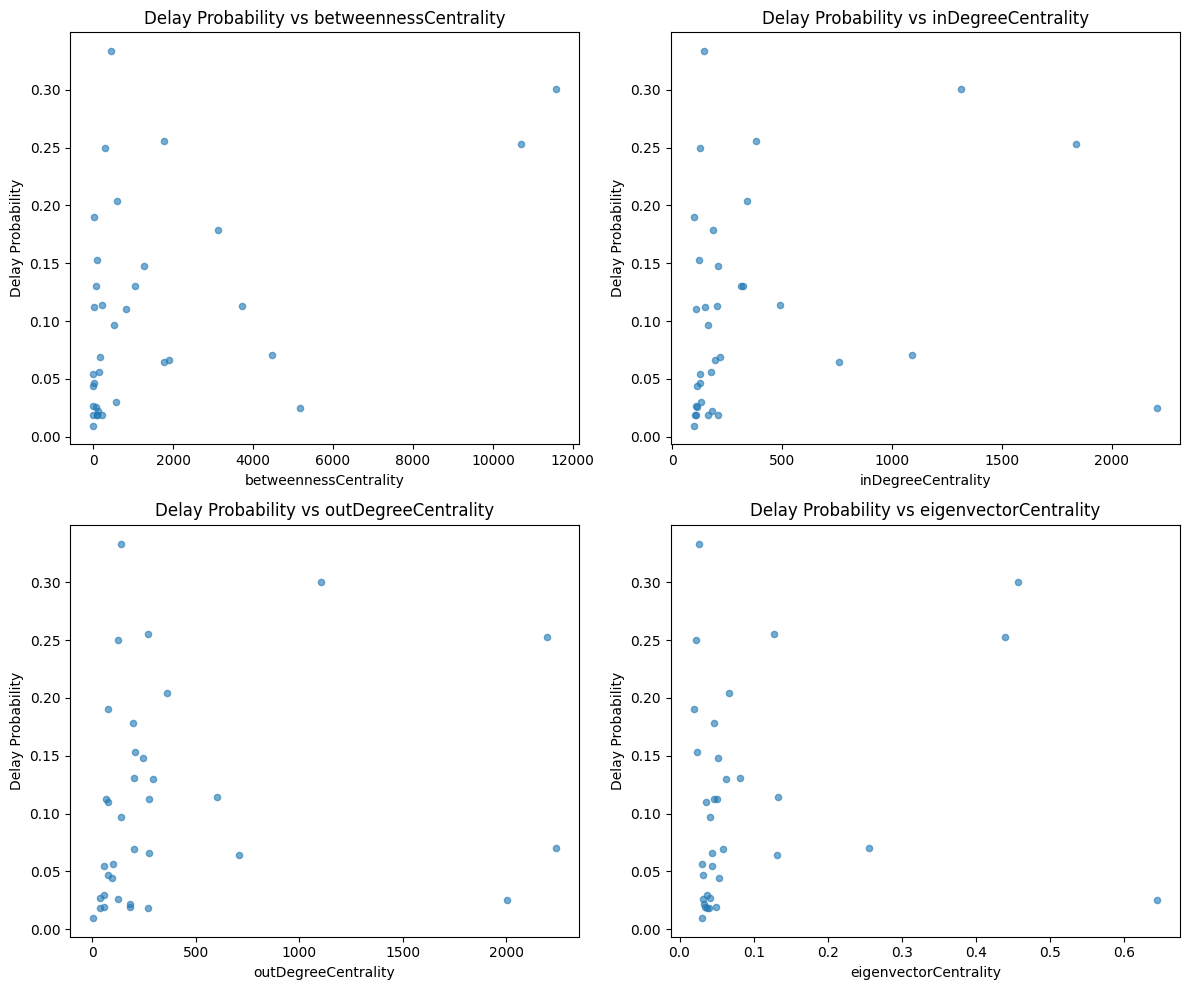

In [40]:
import matplotlib.pyplot as plt

# Scatter plot of centrality vs delay probability
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

centrality_measures = ['betweennessCentrality', 'inDegreeCentrality', 
                      'outDegreeCentrality', 'eigenvectorCentrality']

for i, measure in enumerate(centrality_measures):
    ax = axes[i//2, i%2]
    airport_summary.plot.scatter(x=measure, y='prob', ax=ax, alpha=0.6)
    ax.set_title(f'Delay Probability vs {measure}')
    ax.set_xlabel(measure)
    ax.set_ylabel('Delay Probability')

plt.tight_layout()
plt.show()
